In [1]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     511 non-null    int64  
 1   dteday      511 non-null    object 
 2   season      483 non-null    float64
 3   yr          488 non-null    float64
 4   mnth        483 non-null    float64
 5   holiday     484 non-null    float64
 6   weekday     483 non-null    float64
 7   workingday  484 non-null    float64
 8   weathersit  485 non-null    float64
 9   temp        480 non-null    float64
 10  atemp       481 non-null    float64
 11  hum         489 non-null    float64
 12  windspeed   487 non-null    float64
 13  cnt         511 non-null    int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 56.0+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     219 non-null    int64  
 1   dteday      219 non-null    object 
 2   season      211 non-null    float64
 3   yr          206 non-null    float64
 4   mnth        211 non-null    float64
 5   holiday     210 non-null    float64
 6   weekday     211 non-null    float64
 7   workingday  210 non-null    float64
 8   weathersit  209 non-null    float64
 9   temp        214 non-null    float64
 10  atemp       213 non-null    float64
 11  hum         205 non-null    float64
 12  windspeed   207 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 22.4+ KB


In [7]:
# dteday to datetime
df_train['dteday'] = pd.to_datetime(df_train['dteday'], format='%d-%m-%Y')
    
# 1. Filling nan values
# year
df_train.loc[df_train['yr'].isna(), 'yr'] = df_train.loc[df_train['yr'].isna(), 'dteday'].apply(lambda x: 1 if x.year == 2019 else 0)
# month 
df_train.loc[df_train['mnth'].isna(), 'mnth'] = df_train.loc[df_train['mnth'].isna(), 'dteday'].dt.month
# weekday
df_train.loc[df_train['weekday'].isna(), 'weekday'] = df_train.loc[df_train['weekday'].isna(), 'dteday'].dt.weekday
    
# 2. Holiday & Workingday
def fill_holiday_workingday(row):
    if pd.isna(row['holiday']) and pd.isna(row['workingday']):
        weekday = row['weekday']
        if weekday in [5, 6]:  # 주말
            return 0, 0
        else:  # 평일
            return 0, 1
    elif pd.isna(row['holiday']):
        holiday = 0 if row['workingday'] == 1 else 1
        return holiday, row['workingday']
    elif pd.isna(row['workingday']):
        if row['holiday'] == 0 and row['weekday'] not in [5, 6]:
            return row['holiday'], 1
        else:
            return row['holiday'], 0
    return row['holiday'], row['workingday']
    
missing_mask = df_train['holiday'].isna() | df_train['workingday'].isna()
rows_to_fill = df_train[missing_mask]
filled_values = []
    
for idx, row in rows_to_fill.iterrows():
    h, w = fill_holiday_workingday(row)
    filled_values.append((h, w))
    
df_train.loc[missing_mask, 'holiday'] = [h for h, w in filled_values]
df_train.loc[missing_mask, 'workingday'] = [w for h, w in filled_values]
    
# Season
def get_season(row):
    # Filled season information based on the data
    month = row['dteday'].month
    day = row['dteday'].day
        
    same_date_season = df_train[
        (df_train['mnth'] == month) & 
        (df_train['dteday'].dt.day == day) & 
        (df_train['season'].notna())
    ]['season']
        
    if not same_date_season.empty:
        return same_date_season.mode().iloc[0]
        
    # Or based on the astronomical information
    if month == 12:
        return 1 if day >= 21 else 4  
    elif month == 3:
        return 2 if day >= 21 else 1 
    elif month == 6:
        return 3 if day >= 21 else 2  
    elif month == 9:
        return 4 if day >= 21 else 3 
    elif month in [1, 2]:
        return 1  
    elif month in [4, 5]:
        return 2  
    elif month in [7, 8]:
        return 3  
    elif month in [10, 11]:
        return 4  
    
df_train.loc[df_train['season'].isna(), 'season'] = df_train[df_train['season'].isna()].apply(get_season, axis=1)
    
# fill 'temp', 'atemp', 'windspeed', 'hum' with catboost regressor based using other input features
weather_numeric_features = ['temp', 'atemp', 'windspeed', 'hum']
features_for_prediction = ['mnth', 'season', 'yr', 'holiday', 'weekday', 'workingday']
    
# Nan value check
missing_any = df_train[weather_numeric_features].isna().any().any()
if missing_any:   
    # fillna with catboostregressor
    for target_col in weather_numeric_features:
        if df_train[target_col].isna().any():
            missing_mask = df_train[target_col].isna()
                
            # use other feature values for filling nan if availalbe
            available_numeric = [col for col in weather_numeric_features 
                                if col != target_col and not df_train[col].isna().any()]
            current_features = features_for_prediction + available_numeric
                
            model = CatBoostRegressor(
                iterations=100,
                learning_rate=0.1,
                depth=6,
                loss_function='RMSE',
                verbose=False,                    
                random_seed=42
                )
                
            # Predict nan values
            model.fit(
                df_train[~missing_mask][current_features],
                df_train[~missing_mask][target_col]
            )
                
            predictions = model.predict(df_train[missing_mask][current_features])
            df_train.loc[missing_mask, target_col] = predictions.astype(int)

# filling weathersit nan values using catboostclassifier using all weather related features
if df_train['weathersit'].isna().any():
        
    weather_all_features = ['temp', 'atemp', 'hum', 'windspeed', 'season', 'mnth']
        
    missing_mask = df_train['weathersit'].isna()
    train_data = df_train[~missing_mask].copy()
    predict_data = df_train[missing_mask].copy()
        
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        verbose=False,
        random_seed=42
        )
        
    model.fit(
        train_data[weather_all_features],
        train_data['weathersit']
    )
        
    predictions = model.predict(predict_data[weather_all_features])
    df_train.loc[missing_mask, 'weathersit'] = predictions.astype(int)


# Check dytpe of each column after filling nan values
print("\n각 컬럼의 현재 데이터 타입:")
for col in df_train.columns:
    print(f"{col}: {df_train[col].dtype}")



각 컬럼의 현재 데이터 타입:
instant: int64
dteday: datetime64[ns]
season: float64
yr: float64
mnth: float64
holiday: float64
weekday: float64
workingday: float64
weathersit: float64
temp: float64
atemp: float64
hum: float64
windspeed: float64
cnt: int64


In [8]:
# Drop 'instant' and 'dteday'
df_train.drop(columns=['instant', 'dteday'], inplace=True)

A correalation with target value:
cnt           1.00
atemp         0.64
temp          0.63
yr            0.55
season        0.44
mnth          0.30
workingday    0.10
weekday       0.08
hum          -0.08
holiday      -0.15
windspeed    -0.23
weathersit   -0.27
Name: cnt, dtype: float64


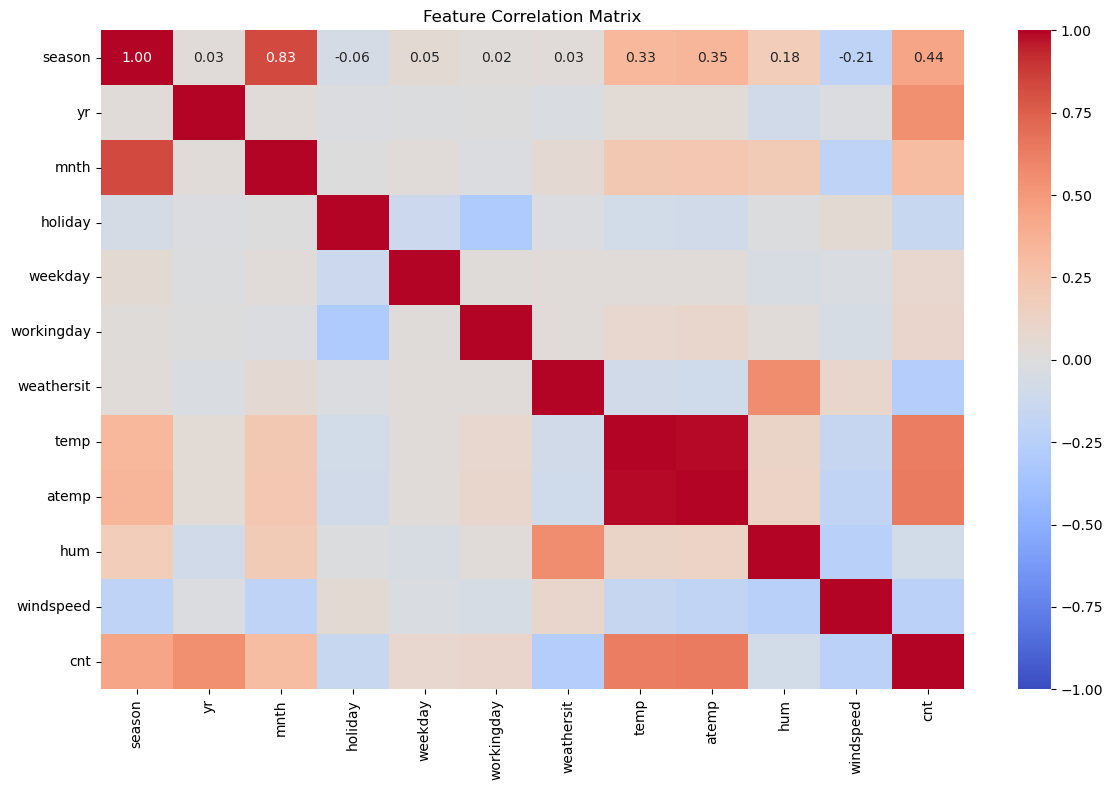

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df_train.corr().round(2)

# 1. 타겟 변수('cnt')와의 상관계수 정렬 (내림차순)
target_corr = corr_matrix['cnt'].sort_values(ascending=False)

print("A correalation with target value:")
print(target_corr)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show correlation values
            annot_kws={"size": 10},  # 폰트 크기 조절
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Display 2 decimal places
            vmin=-1, vmax=1)  # Set min and max values for the colormap

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [10]:
# 다중 공산성
def check_multicollinearity(df, features):
    # 독립변수만 선택
    X = df[features]

    # VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print("VIF (Variance Inflation Factor):")
    print(vif_data.sort_values("VIF", ascending=False))

    return vif_data

features = ['temp', 'atemp', 'hum', 'windspeed']  # 독립변수 목록
vif_result = check_multicollinearity(df_train, features)



VIF (Variance Inflation Factor):
     feature         VIF
1      atemp  592.039758
0       temp  535.706175
2        hum   12.031033
3  windspeed    5.101377


In [11]:
# 1. cnt를 제외한 상관행렬 계산
corr_matrix = df_train.drop(columns=['cnt']).corr().round(2)

# 2. 상관계수 절댓값 기준 내림차순 정렬
# - 상관행렬의 upper triangle을 추출 (중복 제거)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# - 절댓값 기준 정렬된 상관계수 쌍 생성
sorted_corr = upper_triangle.stack().abs().sort_values(ascending=False).reset_index()
sorted_corr.columns = ['feature1', 'feature2', 'abs_correalation']

print("Correalation among independent variables (Descending order):")
print(sorted_corr.head(20))  # 상위 20개만 출력

Correalation among independent variables (Descending order):
      feature1    feature2  abs_correalation
0         temp       atemp              0.99
1       season        mnth              0.83
2   weathersit         hum              0.56
3       season       atemp              0.35
4       season        temp              0.33
5      holiday  workingday              0.30
6          hum   windspeed              0.25
7         mnth       atemp              0.23
8         mnth        temp              0.22
9       season   windspeed              0.21
10        mnth   windspeed              0.21
11        mnth         hum              0.20
12       atemp   windspeed              0.19
13      season         hum              0.18
14        temp   windspeed              0.16
15       atemp         hum              0.13
16     holiday     weekday              0.13
17        temp         hum              0.11
18  weathersit       atemp              0.10
19  weathersit   windspeed             

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


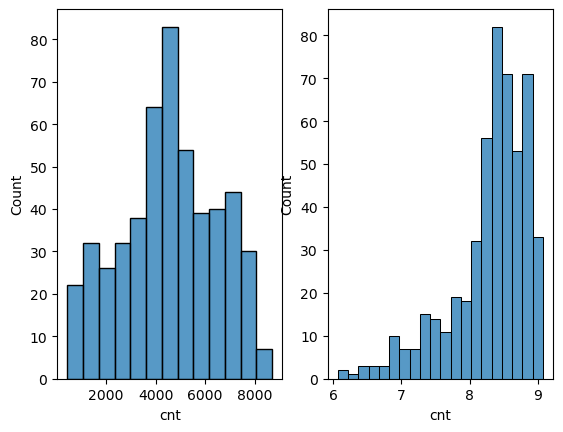

In [12]:
# Before Log transform and after
fig, axes = plt.subplots(1,2)
sns.histplot(df_train['cnt'], ax = axes[0])
sns.histplot(np.log(df_train['cnt']), ax = axes[1])
plt.show()

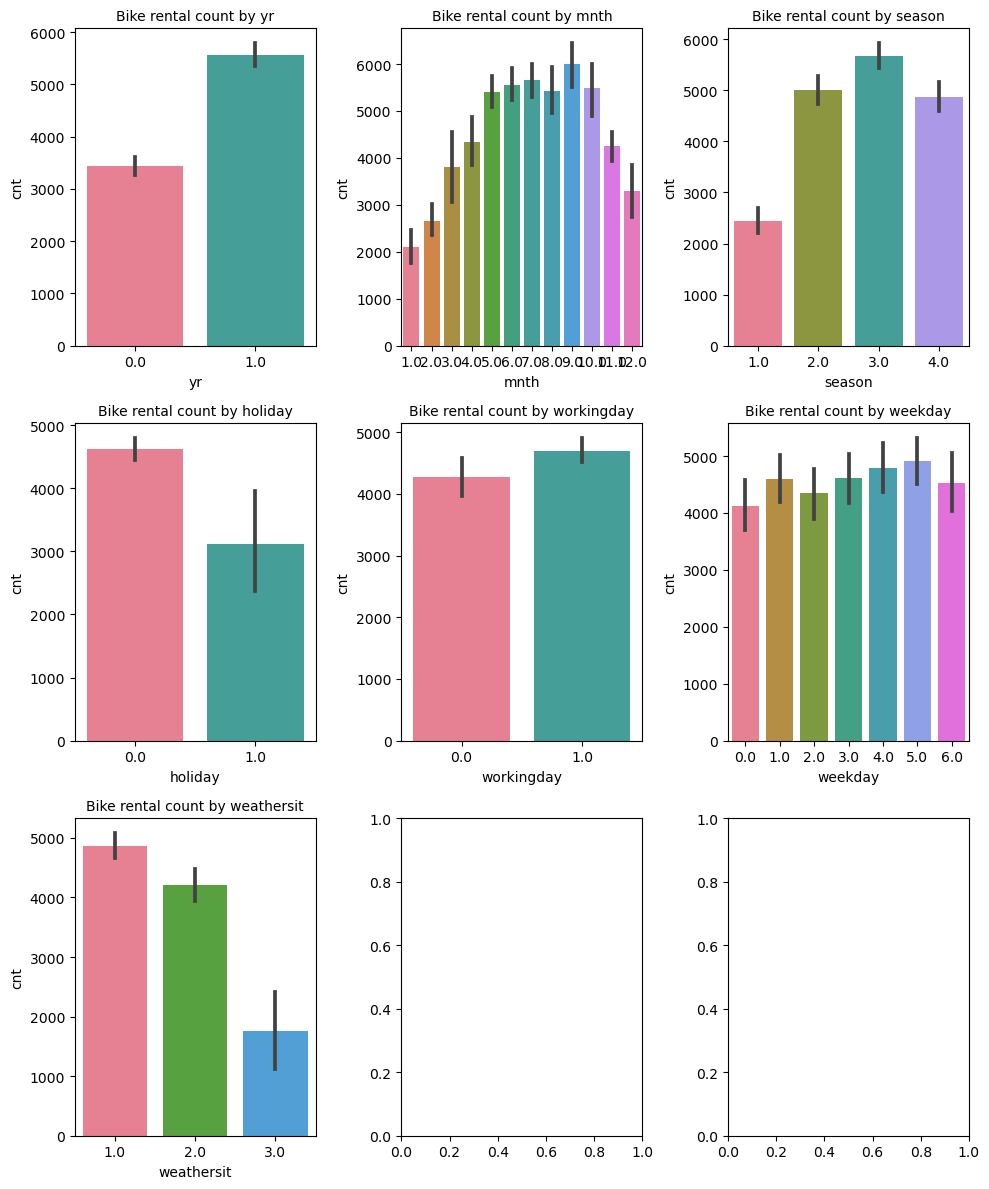

In [13]:
fig_row = 3
fig_col = 3

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 12)

draw_cols = ['yr', 'mnth', 'season', 'holiday', 'workingday', 'weekday', 'weathersit']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.barplot(df_train, x = col, y = 'cnt',
                ax = ax,
                palette='husl')
    ax.set_title('Bike rental count by {}'.format(col))
plt.tight_layout()
plt.show()

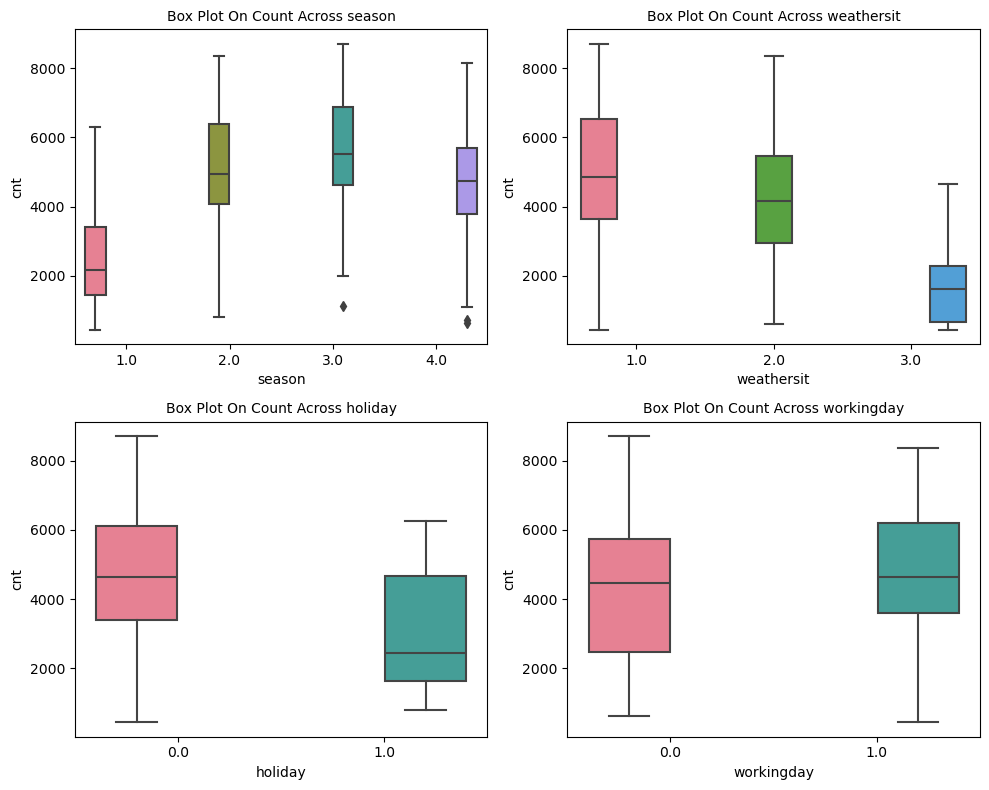

In [14]:
fig_row = 2
fig_col = 2

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 8)

draw_cols = ['season', 'weathersit', 'holiday', 'workingday']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.boxplot(df_train, x = col, y = 'cnt',
                ax = ax,
                palette='husl', hue = col)
    ax.set_title('Box Plot On Count Across {}'.format(col))
    ax.legend().remove()
plt.tight_layout()
plt.show()

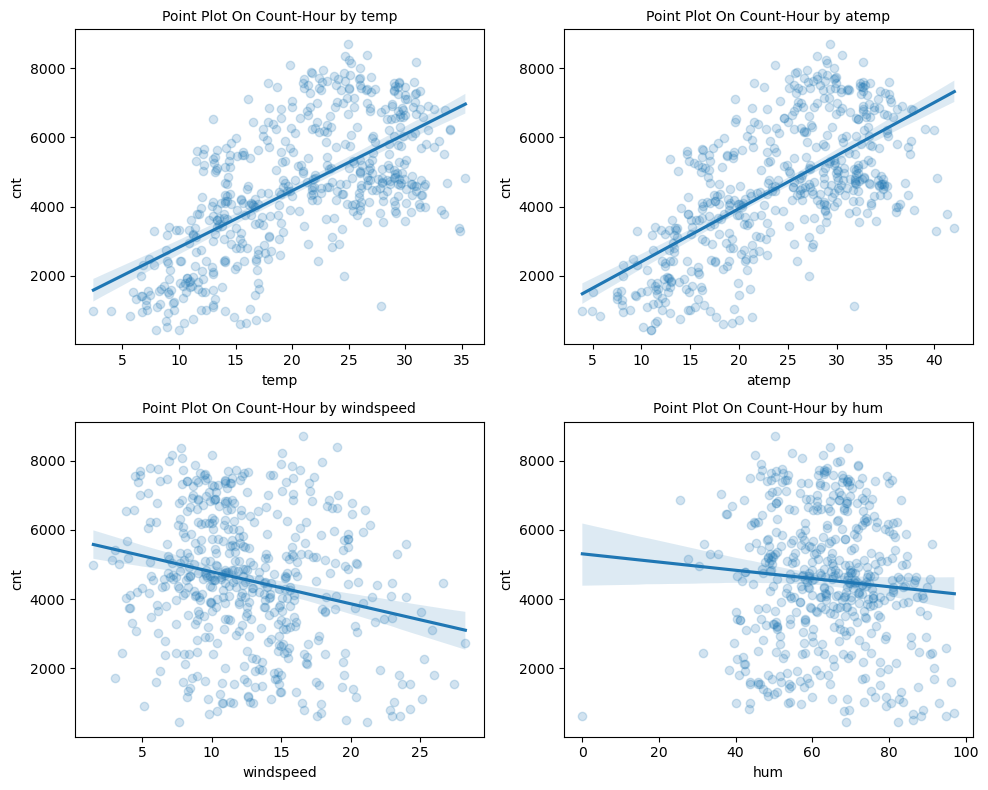

In [15]:
fig_row = 2
fig_col = 2

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 8)

draw_cols = ['temp', 'atemp', 'windspeed', 'hum']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.regplot(df_train, x = col, y = 'cnt',
                ax = ax, scatter_kws={'alpha' : 0.2})
    ax.set_title('Point Plot On Count-Hour by {}'.format(col))
plt.tight_layout()
plt.show()